In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [2]:
sys.path.append("/workspace/HKU-OccNet/")
from utils import SemanticKITTIDataset
from utils import visualize_labeled_array3d
from utils import plot_tensor2d
from torch.utils.data import random_split
from utils.monoscene_utils import *

KITTI_DIR = "/workspace/Dataset/dataset"



train_set = SemanticKITTIDataset(root_dir=KITTI_DIR, mode='train', 
                                 sequences=['00'], split_ratio=0.05)


split_idx = int(0.8 * len(train_set))
train_subset, val_subset = random_split(train_set, [split_idx, len(train_set) - split_idx])


num_classes = len(train_set.class_names)
class_weights = train_set.class_weights

img_width, img_height = 1241, 376

print(len(train_subset))  # 训练集子集的长度
print(len(val_subset))    # 验证集子集的长度


calib = read_calib("/workspace/HKU-OccNet/calib.txt")

#get_projections(img_width, img_height, calib)

181
46


In [3]:
#get_projections(img_width, img_height, calib)['fov_mask_1'].view(256, 256, 32).shape

get_projections(img_width, img_height, calib).keys()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


dict_keys(['projected_pix_1', 'pix_z_1', 'fov_mask_1', 'projected_pix_2', 'pix_z_2', 'fov_mask_2'])

In [4]:
#left_img, right_img, vox_labels = train_set.get_data(666)
# plt.figure(1)
# plot_tensor2d(left_img)
# plt.figure(2)
# plot_tensor2d(right_img)
# plt.show()
#visualize_labeled_array3d(vox_labels.numpy().astype(np.uint16), size = 0.5, marker = 'box')

In [5]:
#left_img.shape

In [75]:
P_rect_02 = torch.tensor([
    [7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
    [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
    [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]
], dtype=torch.float32)
P_rect_03 = torch.tensor([
    [7.215377e+02, 0.000000e+00, 6.095593e+02, -3.395242e+02],
    [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.199936e+00],
    [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.729905e-03]
], dtype=torch.float32)


import torch

def disparity_to_3D_points(disparity, left_prj=P_rect_02, right_prj=P_rect_03):
    """
    Convert disparity map to 3D points using the given projection matrices.

    Parameters:
    - disparity: 2D torch tensor representing the disparity map.
    - left_prj: 3x4 torch tensor representing the left rectified projection matrix.
    - right_prj: 3x4 torch tensor representing the right rectified projection matrix.

    Returns:
    - 3D torch tensor with shape (H, W, 3) representing the 3D points.
    """
    W, H = disparity.shape
    f = left_prj[0, 0]  # Focal length
    T = right_prj[0, 3] / f  # Baseline

    Q = torch.tensor([
        [1, 0, 0, -0.5 * W],
        [0, -1, 0, 0.5 * H],
        [0, 0, 0, -f],
        [0, 0, -1 / T, 0]
    ], dtype=torch.float32)

    # Create meshgrid for pixel coordinates
    u, v = torch.meshgrid(torch.arange(W, dtype=torch.float32), torch.arange(H, dtype=torch.float32))

#     print(u.shape)
#     print(v.shape)
#     print(disparity.shape)
    # Reproject to 3D
    homog_coords = torch.stack((u, v, torch.ones_like(u), disparity), dim=-1)
    points_3D = torch.matmul(homog_coords, Q.transpose(0, 1))
    points_3D = points_3D[:, :, :3] / points_3D[:, :, 3].unsqueeze(-1)  # Convert from homogeneous to 3D coordinates

    return points_3D


#disparity_to_3D_points(disp_img.squeeze(0))

In [5]:
from monoscene.monoscene import MonoScene
from utils.monoscene_utils import *

pretrained_weight_path = '/workspace/PretrainedWeights/monoscene_kitti.ckpt'


monoscene_pt = MonoScene.load_from_checkpoint(
        pretrained_weight_path,
        dataset="kitti",
        n_classes=20,
        feature = 64,
        project_scale = 2,
        full_scene_size = (256, 256, 32),
)




class MonoScene(nn.Module):
    def __init__(self, MonoScene_pretrained, calib, img_width, img_height):
        super(MonoScene, self).__init__()

        self.monoscene_pt = MonoScene_pretrained
        self.batch_dict = get_projections(img_width, img_height, calib)
        for key in self.batch_dict:
            self.batch_dict[key] = self.batch_dict[key].unsqueeze(0)
            self.batch_dict[key] = self.batch_dict[key].to(device)
        
    
    # input_tensor 'x' should be batched stereo image tensor with
    # shape: N x 2 x C x H x W, where N is the batch size, 
    # 2 for left and right images, 
    # and C,H,W are the dimensions of RGB images 
    def forward(self, x):
        #print(x.shape)

        self.batch_dict["img"] = x.to(device)

        x = self.monoscene_pt(self.batch_dict)
        return x



print("Monoscene parameter:", sum(p.numel() for p in monoscene_pt.parameters() if p.requires_grad))
for p in monoscene_pt.parameters():
     p.requires_grad = False

ModuleNotFoundError: No module named 'monoscene'

In [7]:
from utils import load_STTR_model
from utils import NestedTensor, batched_index_select


pretrained_weight_path = '/workspace/PretrainedWeights/kitti_finetuned_model.pth.tar'

sttr_pt = load_STTR_model(pretrained_weight_path)
for param in sttr_pt.parameters():
    param.requires_grad = False


print("Number of parameters (in millions):", sum(p.numel() for p in sttr_pt.parameters()) / 1_000_000, 'M')


class STTR_InputAdapterLayer(nn.Module):
    def __init__(self, downsample=3):
        super(STTR_InputAdapterLayer, self).__init__()
        self.downsample = downsample

    def forward(self, input_tensor):
        input_tensor = input_tensor
        bs, _, _, h, w = input_tensor.shape  # Extract batch size, height, and width

        # Extract left and right images from the input tensor
        left_imgs = input_tensor[:, 0, :, :, :].squeeze(1)
        right_imgs = input_tensor[:, 1, :, :, :].squeeze(1)

        col_offset = int(self.downsample / 2)
        row_offset = int(self.downsample / 2)
        sampled_cols = torch.arange(col_offset, w, self.downsample)[None,].expand(bs, -1).cuda()
        sampled_rows = torch.arange(row_offset, h, self.downsample)[None,].expand(bs, -1).cuda()
        

        # Create NestedTensor for the batch
        nested_tensor = NestedTensor(left_imgs, right_imgs,  
                                    sampled_cols=sampled_cols, sampled_rows=sampled_rows)

        return nested_tensor

class STTR(nn.Module):
    def __init__(self, STTR_pretrained):
        super(STTR, self).__init__()
        self.sttr_adapter_layer = STTR_InputAdapterLayer(downsample=3)
        self.sttr_pt = STTR_pretrained
        
    
    # input_tensor 'x' should be batched stereo image tensor with
    # shape: N x 2 x C x H x W, where N is the batch size, 
    # 2 for left and right images, 
    # and C,H,W are the dimensions of RGB images 
    def forward(self, x): 
        x = self.sttr_adapter_layer(x)
        # bs, _, h, w = x.left.size()
        # feat = self.sttr_pt.backbone(x)
        # tokens = self.sttr_pt.tokenizer(feat)
        # pos_enc = self.sttr_pt.pos_encoder(x)
        # # separate left and right
        # feat_left = tokens[:bs]
        # feat_right = tokens[bs:]  # NxCxHxW
        # # downsample
        # if x.sampled_cols is not None:
        #     feat_left = batched_index_select(feat_left, 3, x.sampled_cols)
        #     feat_right = batched_index_select(feat_right, 3, x.sampled_cols)
        # if x.sampled_rows is not None:
        #     feat_left = batched_index_select(feat_left, 2, x.sampled_rows)
        #     feat_right = batched_index_select(feat_right, 2, x.sampled_rows)
        # attn_weight = self.sttr_pt.transformer(feat_left, feat_right, pos_enc)
        # output = self.sttr_pt.regression_head(attn_weight, x)
        output = self.sttr_pt(x)
        disp_map = output['disp_pred'][0]
        occ_map = output['occ_pred'][0] > 0.5
        disp_map[occ_map] = 0.0
        
        return disp_map




Pre-trained model successfully loaded.
Number of parameters (in millions): 2.513811 M


In [8]:
from utils import sem_scal_loss, geo_scal_loss, CE_ssc_loss
from utils import Header


In [9]:
sttr = STTR(sttr_pt)

In [16]:

monoscene = MonoScene(monoscene_pt, calib, img_width, img_height)

In [17]:
# img shape: 3, 376, 1241 
# voxel shape: 256, 256, 32



In [18]:
class CrossAttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CrossAttentionModule, self).__init__()
        # Define layers for cross-attention
        self.query_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.key_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.value_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value):
        batch_size = query.shape[0]

        # Transform query, key, value
        query = self.query_conv(query)
        key = self.key_conv(key)
        value = self.value_conv(value)

        # Reshape for matmul
        query = query.view(batch_size, -1, query.shape[2]*query.shape[3]*query.shape[4])
        key = key.view(batch_size, -1, key.shape[2]*key.shape[3]*key.shape[4]).permute(0, 2, 1)
        value = value.view(batch_size, -1, value.shape[2]*value.shape[3]*value.shape[4])

        # Attention mechanism
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)
        out = torch.bmm(value, attention.permute(0, 2, 1))

        # Reshape back to original size
        out = out.view(batch_size, -1, query.shape[2], query.shape[3], query.shape[4])
        return out

class VoxelCrossAttn(nn.Module):
    def __init__(self, num_classes):
        super(VoxelCrossAttn, self).__init__()
        self.monoscene = ...  # Your existing MonoScene model
        self.cross_attention = CrossAttentionModule(num_classes, num_classes)
        self.additional_layers = ...  # Additional layers as needed

    def forward(self, pred_1h, vox_proposal):
        mono_pred_1h = pred_1h

        # Cross-attention
        vox_proposal_expanded = vox_proposal.unsqueeze(0).expand_as(mono_pred_1h)
        attn_output = self.cross_attention(vox_proposal_expanded, mono_pred_1h, mono_pred_1h)

        # Additional layers for processing
        output = self.additional_layers(attn_output)

        return output

In [19]:
import torch
import torch.nn as nn

class STFB_Occ(nn.Module):
    def __init__(self, num_classes, sttr, monoscene):
        super(STFB_Occ, self).__init__()
        self.sttr = sttr
        self.monoscene = monoscene
        
        #self.depth_prj_voxel = DepthProjectVoxel()
        

        # Initial convolution layers
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # FPN Layers
        self.toplayer = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        self.latlayer1 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0)

        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.channel_reducer = nn.Conv2d(in_channels=768, out_channels=3, kernel_size=1)
        
        self.cross_attn = VoxelCrossAttn(num_classes)

    def _upsample_add(self, x, y):
        _, _, H, W = y.size()
        return nn.functional.interpolate(x, size=(H, W), mode='bilinear', align_corners=False) + y

    def forward(self, x):
        # Existing STTR depth estimation
        x_depth = self.sttr(x)
        x_depth = x_depth.unsqueeze(0)
        

        left_image = x[:, 0, :, :, :].squeeze(1)  # Shape: [N, C, H, W] (N always 1)
        
        #print(left_image.shape, x_depth.shape)
        #vox_proposal = self.depth_prj_voxel(left_image, x_depth)
        #print(vox_proposal.shape)
        
        
        x = torch.cat((left_image, x_depth.unsqueeze(0)), dim=1)  # Shape: [N, C+1, H, W]

        # Convolution layers
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        c3 = self.conv3(c2)

        # Top-down pathway
        p3 = self.toplayer(c3)
        p2 = self._upsample_add(p3, self.latlayer1(c2))
        p1 = self._upsample_add(p2, self.latlayer2(c1))

        # Smoothing
        p2 = self.smooth1(p2)
        p1 = self.smooth2(p1)

        # Final monoscene processing
        fused_features = torch.cat([p1, p2, p3], dim=1)
        reduced_features = self.channel_reducer(fused_features)
        
        #print(fused_features.shape)
        mono_pred_1h = self.monoscene(reduced_features) 
        # mono_pred_1h has shape [batch_size, num_classes, 255, 255, 32]
        #print(mono_pred_1h.shape) #[1, 20, 256, 256, 32]
        # vox_propasal has shape = [255, 255, 32]
        
        #vox_pred_1h = self.cross_attn(mono_pred_1h, vox_proposal)
        return mono_pred_1h
        #return vox_pred_1h


In [20]:
model = STFB_Occ(num_classes=num_classes, 
                 sttr=sttr, 
                 monoscene=monoscene)
print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000, 'M')


Number of parameters (in millions): 1.670575 M


In [21]:
#model.sttr()

In [22]:
# for i, (image2, image3, voxel_labels) in tqdm(enumerate(train_dataloader),total = len(train_dataloader)):
#     if i == 0:
#         print(image2.shape)
#         print(image3.shape)
#         print(voxel_labels.shape)
#         inputs = torch.stack((image2, image3), dim=1).to(device)
        
#         print(model.sttr(inputs).shape)
#         break

In [23]:
train_dataloader = DataLoader(train_subset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=1, shuffle=True)
print(len(train_dataloader))
print(len(val_dataloader))
model = model.to(device)

181
46


In [20]:
from tqdm import tqdm
from torch.optim import Adam
import torch.nn.functional as F

optimizer = Adam(model.parameters(), lr=0.01)
num_epochs = 3
best_loss = np.inf
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (image2, image3, voxel_labels) in tqdm(enumerate(train_dataloader),total = len(train_dataloader)):
        inputs = torch.stack((image2, image3), dim=1).to(device)
        voxel_labels = voxel_labels.to(device)
        
        voxel_pred_1h = model(inputs)
        
        loss = sem_scal_loss(voxel_pred_1h, voxel_labels)
        loss += geo_scal_loss(voxel_pred_1h, voxel_labels)
        class_weights = class_weights.float().to(device)
        loss += CE_ssc_loss(voxel_pred_1h, voxel_labels, class_weights)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    with torch.no_grad():
        for (image2, image3, voxel_labels) in tqdm(val_dataloader):
            inputs = torch.stack((image2, image3), dim=1).to(device)
            voxel_labels = voxel_labels.to(device)
            
            voxel_pred_1h = model(inputs)
            
            loss = sem_scal_loss(voxel_pred_1h, voxel_labels)
            loss += geo_scal_loss(voxel_pred_1h, voxel_labels)
            class_weights = class_weights.float().to(device)
            loss += CE_ssc_loss(voxel_pred_1h, voxel_labels, class_weights)
            
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'STFBOcc.pth')
        best_loss = (train_loss / len(train_dataloader))

  0%|          | 0/181 [00:00<?, ?it/s]/workspace/stereo-transformer/module/pos_encoder.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/workspace/HKU-OccNet/monoscene/monoscene.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). Th

Epoch 1: Training loss: 13.403556017585881, Validation loss: 13.109460426413495


100%|██████████| 46/46 [00:55<00:00,  1.20s/it]


Epoch 2: Training loss: 13.162726605136092, Validation loss: 12.376740279405013


100%|██████████| 46/46 [00:55<00:00,  1.21s/it]


Epoch 3: Training loss: 13.029085019675408, Validation loss: 12.292784214019775


In [24]:
#device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = STFB_Occ(num_classes=num_classes, sttr=sttr, monoscene=monoscene).to(device)
model.load_state_dict(torch.load('STFBOcc.pth', map_location=device))

<All keys matched successfully>

In [25]:
test_set = SemanticKITTIDataset(root_dir=KITTI_DIR, mode='test', 
                                 sequences=['00'], split_ratio=0.8)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)
len(test_dataloader)

909

In [26]:
left_img, right_img, voxel_labels = test_set.__getitem__(66)
inputs = torch.stack((left_img.unsqueeze(0), right_img.unsqueeze(0)), dim=1).to(device)
voxel_pred_1h = model(inputs)
voxel_pred = torch.argmax(voxel_pred_1h, dim=1)[0,:,:,:]

/workspace/stereo-transformer/module/pos_encoder.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/workspace/HKU-OccNet/monoscene/monoscene.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for ne

In [27]:
visualize_labeled_array3d(voxel_labels.numpy().astype(np.uint16), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [28]:
voxel_pred.shape

torch.Size([256, 256, 32])

In [29]:
visualize_labeled_array3d(voxel_pred.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [30]:
fov_mask1 = get_projections(img_width, img_height, calib)['fov_mask_1'].view(256, 256, 32)
visualize_labeled_array3d(fov_mask1.numpy().astype(np.uint16), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [41]:
left_img, right_img, voxel_labels = train_set.__getitem__(100)
inputs = torch.stack((left_img.unsqueeze(0).numpy(), right_img.unsqueeze(0)), dim=1).to(device)
disp_img = sttr(inputs)
disp_img = disp_img.cpu().unsqueeze(0)


/workspace/stereo-transformer/module/pos_encoder.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


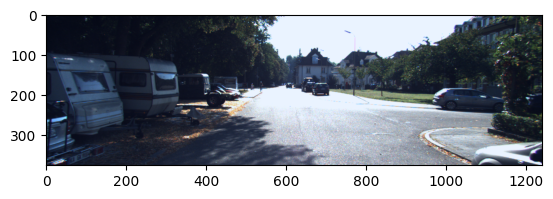

In [42]:
plot_tensor2d(left_img)

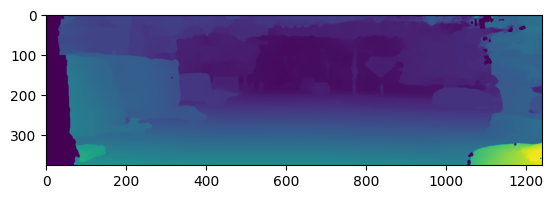

In [58]:
plot_tensor2d(disp_img)

In [60]:
disp_img.shape
disp_img.squeeze(0).shape

torch.Size([376, 1241])

In [87]:
prj3dpts = disparity_to_3D_points(disp_img.squeeze(0))


In [88]:
prj3dpts.shape

torch.Size([376, 1241, 3])

In [ ]:
disp_img.shape

In [32]:
get_projections(img_width, img_height, calib).keys()

dict_keys(['projected_pix_1', 'pix_z_1', 'fov_mask_1', 'projected_pix_2', 'pix_z_2', 'fov_mask_2'])

In [39]:
prj = get_projections(img_width, img_height, calib)

print(prj['projected_pix_1'].view(256, 256, 32, 2).shape)
print(prj['pix_z_1'].view(256, 256, 32).shape)
print(prj['fov_mask_1'].view(256, 256, 32).shape)

torch.Size([256, 256, 32, 2])
torch.Size([256, 256, 32])
torch.Size([256, 256, 32])
